# Preprocessing Wellington Data

**This dataset includes raw data required to calculate carbon emissions, our focus is on studying the decrease in carbon emissions for buses primarily designated for reducing carbon emissions, rather than buses primarily utilized for passenger transportation.**

**While weekend buses tend to be predominantly employed for passenger transportation, it's important to note that weekday buses also serve as a means of passenger transport. However, during weekdays, buses take on an additional role: they are strategically utilized for carbon reduction efforts, particularly during peak hours like 7am-9am and 4pm-6pm.**

### NetBI

The following dimensions were used to generate the datasets

X:
- Actual Running Time
- Actual In-Service KM
- Passenger Km
- Scheduled In-Service Km
- Cancelled Trips
- Sched Running Time per Trip

Y:
- Data
- Route
- Route Variant
- Direction
- Trip Number
- Actual Vehicle Type
- Vehicle Number
- Vehicle Emissions Standard
- Start Minute(Sched)
- Day

### Goals

- <input type="checkbox" checked> Split running time into, hourly run time intervals <input type="checkbox" checked>
- <input type="checkbox" checked> Calculate Average speed of a bus (distance/time) <input type="checkbox" checked> 
- <input type="checkbox" checked> Calculate Average Occupancy (passenger Km/actual km) <input type="checkbox" checked> 
- <input type="checkbox" checked> Calculate Carbon for routes <input type="checkbox" checked>
- <input type="checkbox" checked> Calculate the per person carbon emissions reduction
- <input type="checkbox" checked> Some emissions calculations show below zero. I was able to solve that by data cleaning <input type="checkbox" checked>

### Limitations

- please note, that this analysis does not account for canclelled buses, only those that ran. We have no time to fit this part of analysis in.

### Loading Data

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#read in data from Hamish. This dataframe contains all trips from 1 Jan 2022 to 30 Jule 2023

wlgt2022_trips = pd.read_csv('Wellington Raw Data/trips_updated_2022-01-01_to_2023-06-30.csv')

In [3]:
# set entire tables to be displaed and not truncated

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [4]:
wlgt2022_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688950 entries, 0 to 1688949
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Unnamed: 0                   1688950 non-null  int64  
 1   Date                         1688950 non-null  object 
 2   Route                        1688950 non-null  object 
 3   Route Variant                1688950 non-null  object 
 4   Direction                    1688950 non-null  object 
 5   Service Type                 1688950 non-null  object 
 6   Trip Number                  1688950 non-null  int64  
 7   Vehicle Number               1688950 non-null  object 
 8   Actual Vehicle Type          1688950 non-null  object 
 9   Vehicle Emissions Standard   1688950 non-null  object 
 10  Start Minute (Sched)         1688950 non-null  object 
 11  Actual Running Time          1688950 non-null  int64  
 12  Sched Running Time per Trip  1688950 non-n

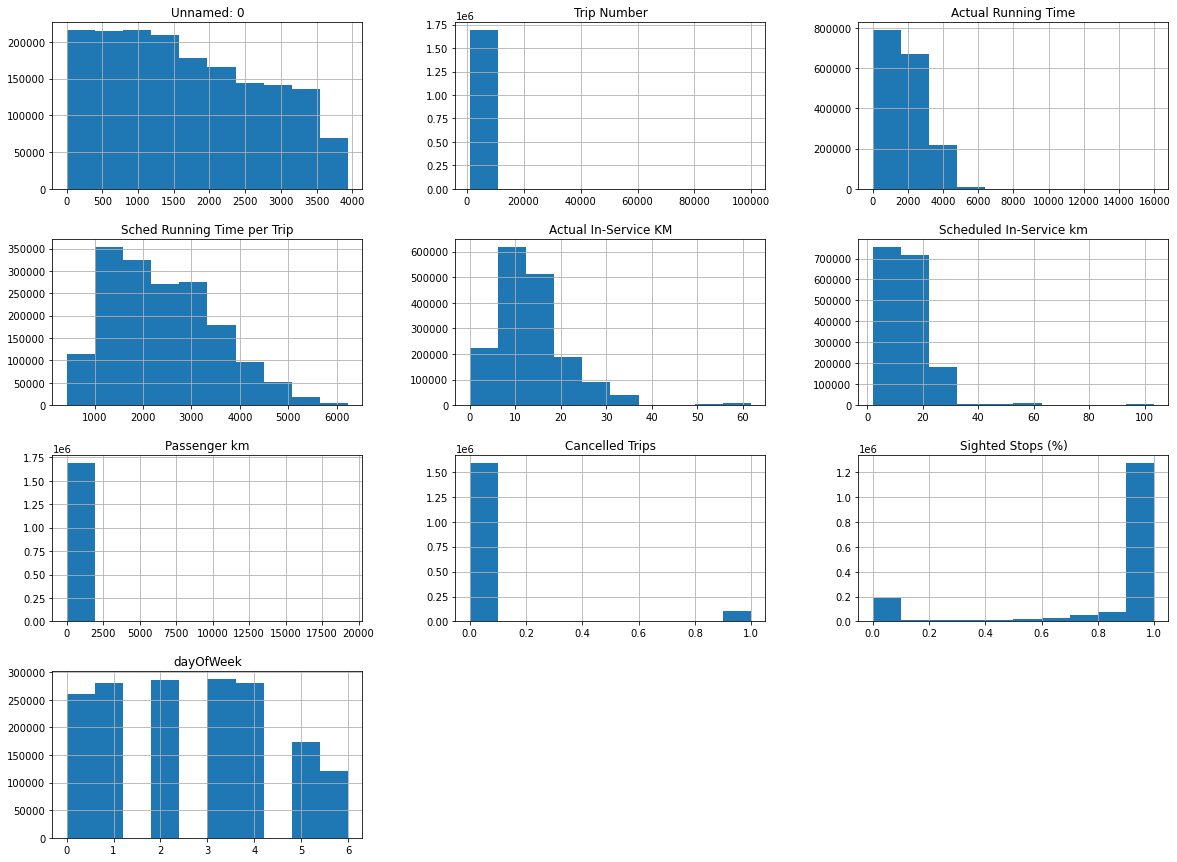

In [5]:
# look an numerical columns
wlgt2022_trips.hist(figsize=(20,15));
fig = plt.gcf()

#### Observations:

- Passenger km over 10 000 looks unrealistic
- sheduled and actual running time over 10,000 also looks unrealistic

#### For reference:

**Actual Vehicle Type**

- ELV = Electric Vehicle
- ELVDD = Electric Double-decker
- DD = Double-Decker
- LV/LV61 = Large (standard) Bus
- MV = Medium Size 
- SV = Small / Shuttle bus

In [6]:
# data cleaning
# drop unnamed 0 column and covnert dates and times to correct format
wlgt2022_trips = wlgt2022_trips.drop(columns=['Unnamed: 0', 'dayOfWeek'])
wlgt2022_trips['Date'] = pd.to_datetime(wlgt2022_trips['Date'])
wlgt2022_trips['Start Minute (Sched)'] = pd.to_datetime(wlgt2022_trips['Start Minute (Sched)'], format='%H:%M').dt.time
wlgt2022_trips['Day of Week'] = wlgt2022_trips['Date'].dt.strftime('%A')

**Trains**
Remove trips with route numbers that contain characters only. We think they are trains. Make exception for AX (Airport Express) and HX (Hospital Express) which are buses.

In [7]:
#remove trips with route numbers that contain characters only. We think they are trains
wlgt2022_trips = wlgt2022_trips[~(wlgt2022_trips['Route'].str.isalpha() & ~wlgt2022_trips['Route'].isin(['HX', 'AX']))]

**Actual Running Time**
Replace unreaslistic actual running time with scheduled running time using arbitrary rule that if actual time is 
 greater than 4 times different from sheduled, something is wrong

In [8]:
anomalies = len(wlgt2022_trips[wlgt2022_trips['Actual Running Time'] / wlgt2022_trips['Sched Running Time per Trip'] > 4])
print("Number of trips where Actual Running Time exceeds schduled Running Time by more than 4 times is", anomalies)

Number of trips where Actual Running Time exceeds schduled Running Time by more than 4 times is 25


In [9]:
#replace unreaslistic actual running time with scheduled running time using arbitrary rule that if actual time is 
#greater than 4 times different from sheduled, something is wrong
wlgt2022_trips['Actual Running Time'] = np.where(
    (wlgt2022_trips['Actual Running Time'] != 0) & 
    (wlgt2022_trips['Actual Running Time'] / wlgt2022_trips['Sched Running Time per Trip'] > 4),
    wlgt2022_trips['Sched Running Time per Trip'],
    wlgt2022_trips['Actual Running Time']
)

In [10]:
wlgt2022_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1670174 entries, 0 to 1688893
Data columns (total 18 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Date                         1670174 non-null  datetime64[ns]
 1   Route                        1670174 non-null  object        
 2   Route Variant                1670174 non-null  object        
 3   Direction                    1670174 non-null  object        
 4   Service Type                 1670174 non-null  object        
 5   Trip Number                  1670174 non-null  int64         
 6   Vehicle Number               1670174 non-null  object        
 7   Actual Vehicle Type          1670174 non-null  object        
 8   Vehicle Emissions Standard   1670174 non-null  object        
 9   Start Minute (Sched)         1670174 non-null  object        
 10  Actual Running Time          1670174 non-null  int64         
 11  Sched Runni

**Bus Speed**

The calculation of bus speed is straightforward and involves the formula where velocity equals the ratio of distance to time ( $ v = \frac{d}{t} $ ).

Since Actual Running Time is in seconds, we divide the time by 3600 to get speed in km her hour.

In [11]:
#Calculate Average speed of a bus (distance/time) with a condition to avoid division by zero
wlgt2022_trips['Speed'] = np.where(wlgt2022_trips['Actual Running Time'] != 0,
                                    wlgt2022_trips['Actual In-Service KM'] / (wlgt2022_trips['Actual Running Time'] / 3600),
                                    0)  # Set Speed to 0 when Running Time is 0

 **Observation**
- Speed above 80km is unrealistic. There are 29774 rows like that. We will replace uprealistic speed with median speed.

In [12]:
unrealistic_speed = len(wlgt2022_trips[wlgt2022_trips['Speed'] > 80])
# proproption of trips with uprealistic speed
print("Percentage of rows with unrealistic speed:", unrealistic_speed/len(wlgt2022_trips)*100, "%")

Percentage of rows with unrealistic speed: 1.782688510298927 %


In [13]:
#median speed excluding trips with zero speed
median_speed = wlgt2022_trips[wlgt2022_trips['Speed'] != 0]['Speed'].median()
wlgt2022_trips['Speed'] = np.where(
    (wlgt2022_trips['Speed'] > 80),
    median_speed,
    wlgt2022_trips['Speed']
)
print("Median speed is", median_speed)

Median speed is 24.136363636363633


**Average Occupancy**

 Mean occupancy (per kilometre driven) equals the ratio Passenger km to Actual In-Service KM
 
 Where Passenger km is a unit of measurement representing the transport of 1 passenger over 1 km
 and Actual In-Service KM is the lengh of a trip


In [14]:
wlgt2022_trips['Average Occupancy'] = np.where(wlgt2022_trips['Actual In-Service KM'] != 0,
                                               wlgt2022_trips['Passenger km']/wlgt2022_trips['Actual In-Service KM'],
                                               0) # Set Occupancy to 0 when Distance travelled is 0

In [15]:
# look into data that we have on Engine Type:
wlgt2022_trips['Vehicle Emissions Standard'].value_counts(normalize=True).reset_index().rename(columns={'index': 'Category', 'Vehicle Emissions Standard': 'Proportion'}).assign(Count=lambda x: x['Proportion'] * len(wlgt2022_trips))    

,Category,Proportion,Count
0,EURO6,0.496096,828566.0
1,ELECTRIC,0.218244,364506.0
2,EURO5,0.099728,166563.0
3,Unknown,0.095301,159170.0
4,EURO3,0.061528,102762.0
5,EURO4,0.029103,48607.0


**Tare Weight**

In [16]:
# Now look up tareWeight of each bus
wlgt2022_fleetmaster = pd.read_csv('Wellington Raw Data/fleet_master.csv')
# Convert the 'Date Modified' column to datetime
wlgt2022_fleetmaster['Date Modified'] = pd.to_datetime(wlgt2022_fleetmaster['Date Modified'], format='%d/%m/%Y')

# filter fleetmaster to leave latest 'Date Modified' data only 
wlgt2022_fleetmaster = wlgt2022_fleetmaster.loc[wlgt2022_fleetmaster.groupby('Vehicle Number')['Date Modified'].idxmax()]

In [17]:
wlgt2022_fleetmaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 7988 to 8606
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date Modified                            622 non-null    datetime64[ns]
 1   Vehicle Number                           622 non-null    object        
 2   Operator                                 622 non-null    object        
 3   Operator Short Code                      622 non-null    object        
 4   Operator Prefix                          622 non-null    object        
 5   Unit Number                              536 non-null    object        
 6   Mode                                     622 non-null    object        
 7   Date of First Registration               573 non-null    object        
 8   Date of Manufacture                      563 non-null    object        
 9   Bike Rack Capable                      

In [18]:
# add tare Weight info to wlgt2022_trips by merging wlgt2022_trips with wlgt2022_fleetmaster
wlgt2022_trips_merged = wlgt2022_trips.merge(wlgt2022_fleetmaster[['Vehicle Number', 'TARE Weight (KG)', 'Vehicle Registration Number']], on='Vehicle Number', how='left')


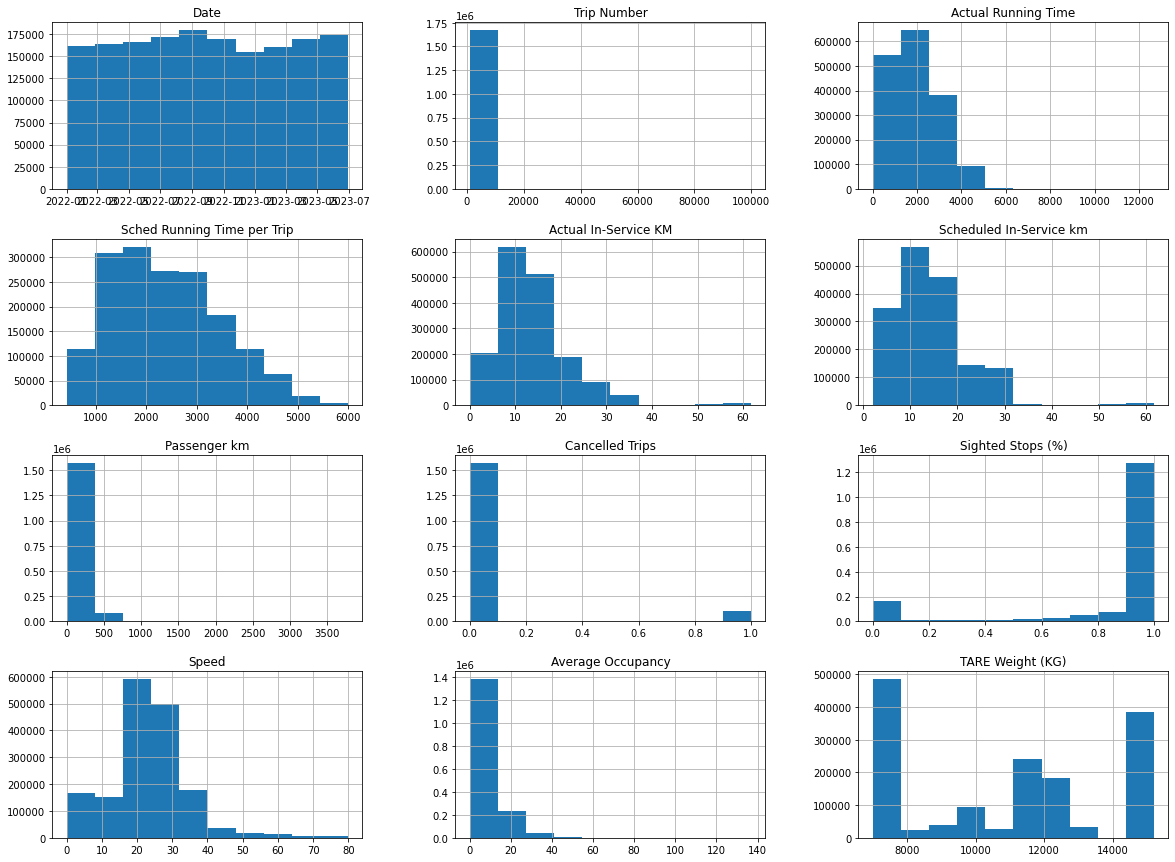

In [19]:
# look an numerical columns
wlgt2022_trips_merged.hist(figsize=(20,15));
fig = plt.gcf()

In [20]:
prop_no_vehicle = len(wlgt2022_trips_merged[wlgt2022_trips_merged['TARE Weight (KG)'].isna()])/len(wlgt2022_trips_merged)*100
print("Proportion of trips with no vehicle data is {:.2f} %".format(prop_no_vehicle))
wlgt2022_trips_merged.info()

Proportion of trips with no vehicle data is 9.65 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1670174 entries, 0 to 1670173
Data columns (total 22 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Date                         1670174 non-null  datetime64[ns]
 1   Route                        1670174 non-null  object        
 2   Route Variant                1670174 non-null  object        
 3   Direction                    1670174 non-null  object        
 4   Service Type                 1670174 non-null  object        
 5   Trip Number                  1670174 non-null  int64         
 6   Vehicle Number               1670174 non-null  object        
 7   Actual Vehicle Type          1670174 non-null  object        
 8   Vehicle Emissions Standard   1670174 non-null  object        
 9   Start Minute (Sched)         1670174 non-null  object        
 10  Actual Running Time        

#### Observations
- of 1670174 trips only 1509041 have Tare Weight info. Proportion of trips with no vehicle data is 9.65 %
- passenger km over 1000 or so look unrealistic. Checked with Chris and decided to keep them.
- There are 92 buses with average occupancy over 100, they appear to be school buses.

**TARE Weight and Vehicle Emissions Standard** 

EURO6, as the most common Emissions Standard in this dataset,  will be used for all "Unknown" vehicles.
Median Tare Weight of EURO6 bus will be used for Missing TARE Weight.

In [21]:
wlgt2022_trips_merged['Vehicle Emissions Standard'] = np.where(
    (wlgt2022_trips_merged['Vehicle Emissions Standard']=='Unknown'),
    'EURO6',
    wlgt2022_trips_merged['Vehicle Emissions Standard']
)

In [22]:
# Calculate the median of 'TARE Weight (KG)' where 'Vehicle Emissions Standard' is 'EURO6'
median_euro6_tare_weight = wlgt2022_trips_merged.loc[wlgt2022_trips_merged['Vehicle Emissions Standard'] == 'EURO6', 'TARE Weight (KG)'].median()

# Fill missing values with the median of EURO6 emissions standard
wlgt2022_trips_merged['TARE Weight (KG)'] = np.where(
    (wlgt2022_trips_merged['TARE Weight (KG)'].isna()),
    median_euro6_tare_weight,
    wlgt2022_trips_merged['TARE Weight (KG)']
)

print("Median TARE Weight for EURO6 standard is", median_euro6_tare_weight, "KG")

Median TARE Weight for EURO6 standard is 7820.0 KG


# Calculate Emissions

In [23]:
#this cell is entering all the constants needed for calcs

LUBE = 0.265170857776354
PASSENGERWEIGHT = 80         #average passenger weight
DIESELDENSITY = 835          # grams per litre
CO2ELECTRIC = 119
emission_equations = [
    {
        "_id": "EURO6",
        "a": -0.00000490907972998,
        "b": -0.0138698794326,
        "g": 2.65774563711,
        "d": 3.2553615439,
        "e": -0.000051285329923,
        "z": 0.00498758025146,
        "h": 0.125550793946
    },
    {
        "_id": "EURO5",
        "a": -0.0000367698590941,
        "b": -0.0134678044879,
        "g": 3.05911007786,
        "d": 3.55505145507,
        "e": -0.0000618780508159,
        "z": 0.00594233596222,
        "h": 0.142419853084
    },
    {
        "_id": "EURO4",
        "a": 0.00251040331347,
        "b": -0.0863970747847,
        "g": 1.10983487462,
        "d": 14.7776496863,
        "e": 0.000327986189114,
        "z": -0.0130053588546,
        "h": 0.218081753103
    },
    {
        "_id": "EURO3",
        "a": 0.00000421475875959,
        "b": 0.0207160939587,
        "g": 1.73463013954,
        "d": 7.0692144528,
        "e": -0.0000197902932034,
        "z": 0.0062379661034,
        "h": 0.0627620452536
    },
    {
        "_id": "EURO2",
        "a": 0.00000840769603463,
        "b": 0.0200800121334,
        "g": 1.65858316407,
        "d": 6.77362500033,
        "e": -0.0000201599863213,
        "z": 0.00634399262596,
        "h": 0.0638032158354
    },
    {
        "_id": "EURO1",
        "a": -0.00000137497057894,
        "b": 0.0209960875758,
        "g": 1.88066742017,
        "d": 7.94657629399,
        "e": -0.0000215438923697,
        "z": 0.00682789815225,
        "h": 0.00682789815225
    },
    {
        "_id": "PREEURO",
        "a": -0.00000656462584868,
        "b": 0.0178339567319,
        "g": 1.79325857679,
        "d": 7.7207331411,
        "e": -0.0000181010843656,
        "z": 0.00549860697303,
        "h": 0.045663294005
    }
]

#The following are 
CH4 = {
    "PREEURO": 0.175,
    "EURO1": 0.175,
    "EURO2": 0.11375,
    "EURO3": 0.10325,
    "EURO4": 0.00525,
    "EURO5": 0.00525,
    "EURO6": 0.00525,
    "CO2FACTOR": 25
}

# N2O.CO2FACTOR converts the N20 realsed to its C02 equivilent. 
# This is to say, how much greenhouse effect does this have over its time in the apnosphere. 
# How much CO2 is needed to have the same effect as this much N20. 
# The numbers we have in the code are used by a previous group however I did my own research and found slightly different numbers. I really want to put them in but I don't know where their numbers come from and I can't find any through research.

# CalcN20 is the greenhouse effectivness of N20 compared to CO

# Just looking at this it looks wrong.
# I would think taht the numbers would decrease as the euros get smaller, not increase. 
# I think that it is reasonable to say that the numbers are the wrong way around. 
# However for consistency with BEAn I am keeping it as is.
N2O = {
    "PREEURO"  : 0.030,            
    "EURO1"     : 0.012,
    "EURO2"     : 0.012,
    "EURO3"     : 0.006,
    "EURO4"     : 0.0128,
    "EURO5"     : 0.0332,
    "EURO6"     : 0.0415,
    "CO2FACTOR": 298
}

In [24]:
# this cell defines a function for emissions calculation

# calculate the emissions in grams 

# the calculation is for CO2e, including CH4 and N2O

# You can access the dictionary for each engine using the engine name as the key.

def calcCO2equiv(row):
    
    
    tareWeight = row['TARE Weight (KG)'] 
    aveOccupancy = row['Average Occupancy'] 
    distance = row['Actual In-Service KM']
    speed = row['Speed']
    euro = row['Vehicle Emissions Standard']
    
    if speed == 0:
        CO2emissions = 0 
    elif euro == 'ELECTRIC':
        CO2emissions = distance*CO2ELECTRIC/1000 
    elif euro =='Unknown':
        CO2emissions = np.nan
    else:
        for item in emission_equations: #looking up values for calculating fuel consumption depending on engine type
            if item["_id"] == euro:
                a = item["a"]
                b = item["b"]
                g = item["g"]
                d = item["d"]
                e = item["e"]
                z = item["z"]
                h = item["h"]

                
        # **Step 1.** Calculate weight factors:

        loadedWeight = tareWeight + aveOccupancy * PASSENGERWEIGHT
        tareFactor =   (0.00004711 * tareWeight) + 0.446
        loadedFactor = (0.00004711 * loadedWeight) + 0.446
        # **Step 2** Calculate fuelConsumed
        fuelConsumedStandard = 100/(45.79 * DIESELDENSITY/1000)*(a * speed**2+b * speed+g+d/speed)/(e*speed**2 + z*speed + h) #L/lm
        #note: ** is power operator (^)
        fuelConsumedAdjusted = fuelConsumedStandard * (loadedFactor * distance + tareFactor * distance*0.15) 
        # note: distance*0.15 is repositioning distance 
        # The 0.15 is accounting for an approximation 15% of the journey the bus travels to either get back to the bus depo or start the next route
        # **Step 3** Calculate fuelEmissions
        fuelEmissions = fuelConsumedAdjusted * 69.31 * DIESELDENSITY * 45.79/100000 #69.31 is CO2 emission factor (tCO2/TJ)
        oilEmissions = distance * LUBE
                
        #**Step 4.** Add emissions from all pollutants: 
        CH4Emissions = distance * CH4[euro] * CH4['CO2FACTOR']
        N2OEmissions = distance * N2O[euro] * N2O['CO2FACTOR']
        CO2emissions = fuelEmissions + oilEmissions+CH4Emissions+N2OEmissions
               
    return CO2emissions
    
    

In [25]:
wlgt2022_trips_merged['CO2emissions'] = wlgt2022_trips_merged.apply(calcCO2equiv, axis = 1)

In [26]:
wlgt2022_trips_merged['CO2emissions'].describe()

count    1.670174e+06
mean     8.365427e+03
std      8.084012e+03
min      0.000000e+00
25%      1.969450e+00
50%      7.302904e+03
75%      1.274469e+04
max      5.958477e+04
Name: CO2emissions, dtype: float64

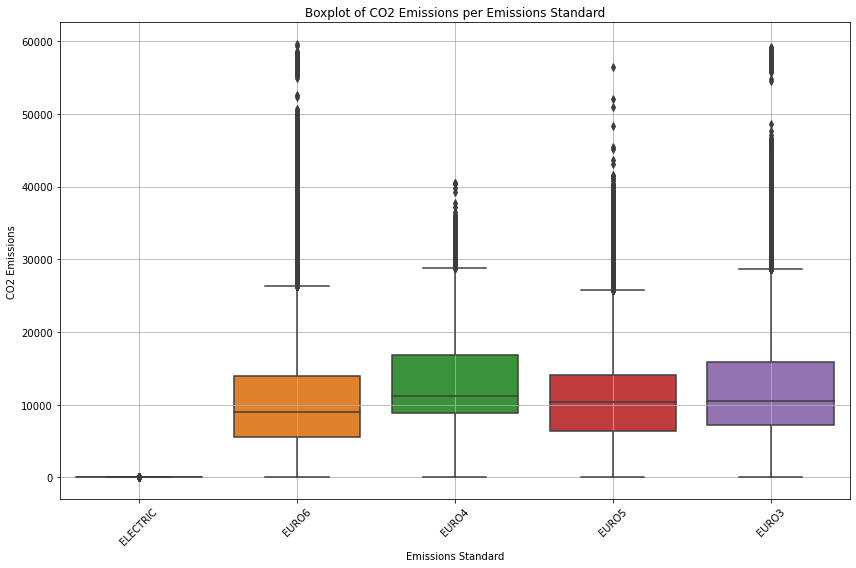

In [27]:
# just checking how this looks:
import seaborn as sns
import matplotlib.pyplot as plt

forPlot = wlgt2022_trips_merged.copy()
forPlot['CO2emissions'] = pd.to_numeric(forPlot['CO2emissions'], errors='coerce')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Vehicle Emissions Standard', y='CO2emissions', data=forPlot)
plt.xticks(rotation=45)
plt.xlabel('Emissions Standard')
plt.ylabel('CO2 Emissions')
plt.title('Boxplot of CO2 Emissions per Emissions Standard')
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculate CO2 savings* 
**\*saved emissions as a result of taking a bus compared to car**

**Average car occupancy**

We use the assumption that on average 1.3 passengers travel in each car. To calculate how many Car km it would take to transport the same number of passengers we divide Passenger km by 1.3

**CO_2 emissions**

CO_2 are taken to be 0.265 kg per Car km. 
To calculate how much CO_2 would be emitted if the bus passengers travelled by a private car we use the following calculation:
$$ CO_2 emissions = \frac{0.265\times Passenger km}{1.3} $$

**Valuation of CO_2 emissions**

The whole-of-government agreed shadow price of carbon ($ per tonne of CO2 equivalent) emissions, in Table 1, is to be used for calculating the economic impact of carbon for transport activities.  This means applying the **central** price path as the default analysis in the economic evaluation of transport proposals and accompanying this with sensitivity analysis based on the low and high price paths. Quoted from here: https://www.nzta.govt.nz/assets/resources/monetised-benefits-and-costs-manual/Monetised-benefits-and-costs-manual.pdf

Table 1: Shadow Price of Carbon (NZ$2022 per tonne of CO2 equivalent)



| Year  | 2023  | 2024  | 2025  | 2026  | 2027  | 2028  | 2029  | 2030  | 2031  | 2032  | 2033  | 2034  |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Low   | \$59  | \$65  | \$72  | \$78  | \$85  | \$91  | \$98  | \$104 | \$108 | \$112 | \$116 | \$120 |
| Middle| \$87  | \$97  | \$107 | \$116 | \$126 | \$136 | \$146 | \$155 | \$161 | \$167 | \$174 | \$180 |
| High  | \$171 | \$182 | \$193 | \$203 | \$214 | \$219 | \$224 | \$230 | \$235 | \$241 | \$247 | \$253 |


Therefore the calculation for shadow cost of CO_2 if the same trip was taken by private cars looks as follows:
(dividing by 1000 as price is per tonne)

$$ CO_2 shadow \ cost = \frac{0.265\times Passenger km\times \$\ Middle \ price for 2023}{1.3\times1000}  - Value \ of \ bus \ trip \ CO2 \ Emissions $$

Please note that part of our data is from 2022, so technically we should be using 2022 price for that part:
Should your analysis require shadow prices for years prior to 2023, email MBCM@nzta.govt.nz.  

In [28]:
# calculate dollar value of emissions from bus trips
# CO2emissions are in gramms, price is per tonne, so we divide by 10^6 to covnert
#you can update shadow price here if you want to use it for a different year
shadow_price2023 = 87

wlgt2022_trips_merged['Emissions Value, $'] = wlgt2022_trips_merged['CO2emissions']*shadow_price2023/10**6

In [29]:
wlgt2022_trips_merged['Emissions Savings, $'] = wlgt2022_trips_merged['Passenger km']*0.265*shadow_price2023/(1.3*1000)-wlgt2022_trips_merged['Emissions Value, $']

In [30]:
#output csv of all routes with emissions
wlgt2022_trips_merged.to_csv("wlgt2022_CO2emissions.csv")

**Aggregating data**

by "Route", "Day of Week", "Start Minute (Sched)" 

In [31]:
#first filter data for 22/23 financial year
wlgt2022_trips_fy2223 = wlgt2022_trips_merged[(wlgt2022_trips_merged['Date'] >= '2022-07-01') & 
                                     (wlgt2022_trips_merged['Date'] < '2023-07-01')]

# grouping data that is split by the hour

wlgt2022_trips_fy2223['CO2emissions'] = pd.to_numeric(wlgt2022_trips_fy2223['CO2emissions'], errors='coerce')

# Group by "Route," "Day of Week," and "Start Minute" and aggregate using desired functions

wlgt2022_trips_aggregated_by_route = wlgt2022_trips_fy2223.groupby(["Route", "Day of Week", "Start Minute (Sched)"]).agg({
    "Trip Number": "count",  # Count of trips
    "Actual Running Time": "mean",  # Mean of running times
    "Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Passenger km": "sum",  # Sum of passenger km
    'Speed': "mean",
    'Average Occupancy': 'mean',
    'CO2emissions': lambda x: x.sum() / 1000,  # Calculate sum of CO2emissions and divide by 1000 to convert to KG
    'Emissions Value, $': "sum",
    'Emissions Savings, $': "sum"
}).reset_index()

# rename the columns for clarity
wlgt2022_trips_aggregated_by_route.columns = ["Route", "Day of Week", "Start Minute (Sched)", "Trip Count", "Mean Running Time",
                         "Total Actual In-Service KM", "Total Passenger KM", "Mean Speed", "Mean Occupancy", 
                         "Total CO2 Emissions, KG", "Total Emissions Value, $", "Total Emissions Savings, $"]

C:\Users\oxant\AppData\Local\Temp\ipykernel_24920\3956181502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wlgt2022_trips_fy2223['CO2emissions'] = pd.to_numeric(wlgt2022_trips_fy2223['CO2emissions'], errors='coerce')


In [33]:
wlgt2022_trips_aggregated_by_route.to_csv("wlgt2022_trips_aggregated_by_route.csv")
wlgt2022_trips_aggregated_by_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28875 entries, 0 to 28874
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Route                       28875 non-null  object 
 1   Day of Week                 28875 non-null  object 
 2   Start Minute (Sched)        28875 non-null  object 
 3   Trip Count                  28875 non-null  int64  
 4   Mean Running Time           28875 non-null  float64
 5   Total Actual In-Service KM  28875 non-null  float64
 6   Total Passenger KM          28875 non-null  float64
 7   Mean Speed                  28875 non-null  float64
 8   Mean Occupancy              28875 non-null  float64
 9   Total CO2 Emissions, KG     28875 non-null  float64
 10  Total Emissions Value, $    28875 non-null  float64
 11  Total Emissions Savings, $  28875 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 2.6+ MB


**Splitting data by the hour**

This workds, however it does not work if the start minute is at 23:something. Need to fix this.

In [34]:
from datetime import datetime, timedelta
# Function to split rows by hour
def split_rows_by_hour(row):
    columns_list = ["Total Actual In-Service KM", "Total Passenger KM",
                    "Total CO2 Emissions, KG", "Total Emissions Value, $", "Total Emissions Savings, $"] #these columns will be updated proportionately
    start_minute = pd.to_datetime(row["Start Minute (Sched)"], format = "%H:%M:%S")
    total_time = row["Mean Running Time"]
    step = 3600  # Split every hour, since our data is in seconds
    rows = []

    while total_time > 0:
        new_row = row.copy()
        new_row["Trip Hour"] = "{:02d}:00".format(start_minute.hour)
        
        if total_time >= step - start_minute.minute*60:
            new_row["Mean Running Time"] = step-start_minute.minute*60
        else:
            new_row["Mean Running Time"] = total_time

        proportion = new_row["Mean Running Time"] / row["Mean Running Time"]
        for column in columns_list:
            new_row[column] = row[column] * proportion
        rows.append(new_row)
        total_time -= new_row["Mean Running Time"]
        start_minute += timedelta(hours=1)
        start_minute = start_minute.replace(minute=0, second=0)

    return pd.DataFrame(rows)

In [35]:
wlgt2022_trips_by_hour = pd.concat(
    wlgt2022_trips_aggregated_by_route.apply(split_rows_by_hour, axis=1).tolist(),
    ignore_index=True
)

In [36]:
wlgt2022_trips_by_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42052 entries, 0 to 42051
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Route                       42052 non-null  object 
 1   Day of Week                 42052 non-null  object 
 2   Start Minute (Sched)        42052 non-null  object 
 3   Trip Count                  42052 non-null  int64  
 4   Mean Running Time           42052 non-null  float64
 5   Total Actual In-Service KM  42052 non-null  float64
 6   Total Passenger KM          42052 non-null  float64
 7   Mean Speed                  42052 non-null  float64
 8   Mean Occupancy              42052 non-null  float64
 9   Total CO2 Emissions, KG     42052 non-null  float64
 10  Total Emissions Value, $    42052 non-null  float64
 11  Total Emissions Savings, $  42052 non-null  float64
 12  Trip Hour                   42052 non-null  object 
dtypes: float64(8), int64(1), object

**Aggregate again**
- by "Route", "Day of Week", "Trip Hour"

In [37]:
wlgt2022_trips_by_hour_aggregated = wlgt2022_trips_by_hour.groupby(["Route", "Day of Week", "Trip Hour"]).agg({
    "Trip Count": "sum",  # Count of trips
    "Mean Running Time": "mean",  # Mean of running times
    "Total Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Total Passenger KM": "sum",  # Sum of passenger km
    'Mean Speed': "mean",
    'Mean Occupancy': 'mean',
    "Total CO2 Emissions, KG": "sum",  # Calculate sum of CO2emissions
    "Total Emissions Value, $": "sum",
    "Total Emissions Savings, $": 'sum',
}).reset_index()

#calculate emissions per pax_km
wlgt2022_trips_by_hour_aggregated['Emissions/paxKM'] = wlgt2022_trips_by_hour_aggregated["Total CO2 Emissions, KG"]/wlgt2022_trips_by_hour_aggregated['Total Passenger KM']

In [38]:
wlgt2022_trips_by_hour_aggregated.to_csv("wlgt2022_trips_by_hour_aggregated.csv")

In [39]:
wlgt2022_trips_by_hour_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7573 entries, 0 to 7572
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Route                       7573 non-null   object 
 1   Day of Week                 7573 non-null   object 
 2   Trip Hour                   7573 non-null   object 
 3   Trip Count                  7573 non-null   int64  
 4   Mean Running Time           7573 non-null   float64
 5   Total Actual In-Service KM  7573 non-null   float64
 6   Total Passenger KM          7573 non-null   float64
 7   Mean Speed                  7573 non-null   float64
 8   Mean Occupancy              7573 non-null   float64
 9   Total CO2 Emissions, KG     7573 non-null   float64
 10  Total Emissions Value, $    7573 non-null   float64
 11  Total Emissions Savings, $  7573 non-null   float64
 12  Emissions PP                7573 non-null   float64
dtypes: float64(9), int64(1), object(3

## Aggregatte data by vehicle per year

In [40]:
# aggregate by Vehicle Number
wlgt_fy2223_emissions_by_vehicle = wlgt2022_trips_fy2223.groupby(["Vehicle Number", 'Actual Vehicle Type', 'Vehicle Emissions Standard',
                                                                 'Vehicle Registration Number', 'TARE Weight (KG)']).agg({
    "Trip Number": "count",  # Count of trips
    'Route': lambda x: ', '.join(x.unique()),  # Combine unique routes as a comma-separated string
    'Service Type': lambda x: ', '.join(x.unique()),  # Combine unique routes as a comma-separated string
    "Actual Running Time": "sum",  # Sum of running times
    "Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Passenger km": "sum",  # Sum of passenger km
    "Cancelled Trips": "sum", 
    'Speed': "mean",
    'Average Occupancy': 'mean',
    'CO2emissions': lambda x: x.sum() / 1000,  # Calculate sum of CO2emissions and divide by 1000 to convert to KG
   'Emissions Value, $': "sum",
    'Emissions Savings, $': "sum",
    
}).reset_index()

# rename the columns for clarity
wlgt_fy2223_emissions_by_vehicle.columns = ['Vehicle Number', 'Vehicle Type','Vehicle Emissions Standard',
                                              'Vehicle Registration Number', 'TARE Weight (KG)',
                                            'Total Trips', 'Routes', 'Service Types',
                                              'Total Running Time',
                                               'Total In-Service KM', 'Total Passenger KM', 'Cancelled Trips Count',
                                               'Average Speed', 'Average Occupancy',
                                               'Total CO2 Emissions, KG', 'Total Emissions Value, $',
                                               'Total Emissions Savings, $']

# calculate emissions per vehicle km travelled
wlgt_fy2223_emissions_by_vehicle['Emissions per VKT'] = wlgt_fy2223_emissions_by_vehicle['Total CO2 Emissions, KG']/wlgt_fy2223_emissions_by_vehicle['Total In-Service KM']

In [41]:
# store data grragated by vehicle to csv file 
wlgt_fy2223_emissions_by_vehicle.to_csv('wlgt_fy2223_emissions_by_vehicle.csv')

In [42]:
#aggregate data by bus size and Euro diesel standard
wlgt_fy2223_emissions_by_EUROclass = wlgt_fy2223_emissions_by_vehicle.groupby(['Vehicle Emissions Standard',
                                                                               'TARE Weight (KG)']).agg({
    "Total Trips": "sum",  # Sum of numer of trips
    "Total Running Time": lambda x: x.sum() / 3600,  # Sum of running times converted from seconds to hours
    "Total In-Service KM": "sum",  # Sum of scheduled in-service km
    "Total Passenger KM": "sum",  # Sum of passenger km
    "Cancelled Trips Count": "sum", 
    'Average Speed': "mean",
    'Average Occupancy': 'mean',
    'Total CO2 Emissions, KG': 'sum',
    'Total Emissions Value, $': "sum",
    'Total Emissions Savings, $': "sum",
    'Emissions per VKT': 'mean',    
}).reset_index()

In [43]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
wlgt_fy2223_emissions_by_EUROclass

,Vehicle Emissions Standard,TARE Weight (KG),Total Trips,Total Running Time,Total In-Service KM,Total Passenger KM,Cancelled Trips Count,Average Speed,Average Occupancy,"Total CO2 Emissions, KG","Total Emissions Value, $","Total Emissions Savings, $",Emissions per VKT
0,ELECTRIC,11500.0,7163,5120.652500,117982.160,1.680109e+06,31,18.262906,13.325983,1.244046e+01,1.082320,29794.995962,0.000106
1,ELECTRIC,11520.0,12892,10365.746667,216076.745,3.187384e+06,70,19.788029,13.908015,2.498131e+01,2.173374,56524.852757,0.000116
2,ELECTRIC,11570.0,2859,2169.566944,44402.095,6.424229e+05,13,20.110286,13.248803,5.217616e+00,0.453933,11392.668989,0.000118
3,ELECTRIC,11580.0,12601,9300.910000,202321.079,2.995228e+06,69,18.786112,13.708721,2.234577e+01,1.944082,53117.278801,0.000110
4,ELECTRIC,11590.0,2620,2019.782500,41331.299,6.111391e+05,15,20.113134,13.583496,4.842553e+00,0.421302,10837.895352,0.000117
5,ELECTRIC,11600.0,2408,1915.976944,39376.628,5.693407e+05,15,20.175557,13.576298,4.630326e+00,0.402838,10096.635783,0.000118
6,ELECTRIC,11960.0,897,682.988333,13458.146,1.979886e+05,3,19.028682,13.713573,1.563299e+00,0.136007,3511.115735,0.000116
7,ELECTRIC,11980.0,1769,1239.515833,24382.220,3.381841e+05,14,18.734564,12.363610,2.835877e+00,0.246721,5997.318204,0.000116
8,ELECTRIC,12000.0,2296,1469.570556,31987.284,4.486980e+05,19,18.133561,12.767549,3.425264e+00,0.297998,7957.188243,0.000110
9,ELECTRIC,12020.0,2584,1805.391667,35867.692,5.085536e+05,15,18.243065,12.652381,4.125771e+00,0.358942,9018.643415,0.000115


# Plotting results

Please note these are only initial ideas. We used Tableau Plots with exported CSV files.

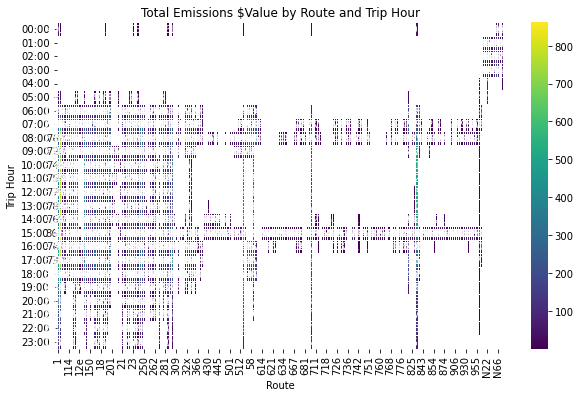

In [45]:
import seaborn as sns
# Create a heatmap to visualize the data
# Create a heatmap to visualize the data
pivot_table = wlgt2022_trips_by_hour_aggregated.pivot_table(index='Trip Hour', columns='Route', values='Total Emissions Value, $')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.1f', linewidths=.5)
plt.title('Total Emissions $Value by Route and Trip Hour')
plt.xlabel('Route')
plt.ylabel('Trip Hour')
plt.show()

C:\Users\oxant\AppData\Local\Temp\ipykernel_24920\2344242752.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\oxant\AppData\Local\Temp\ipykernel_24920\2344242752.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


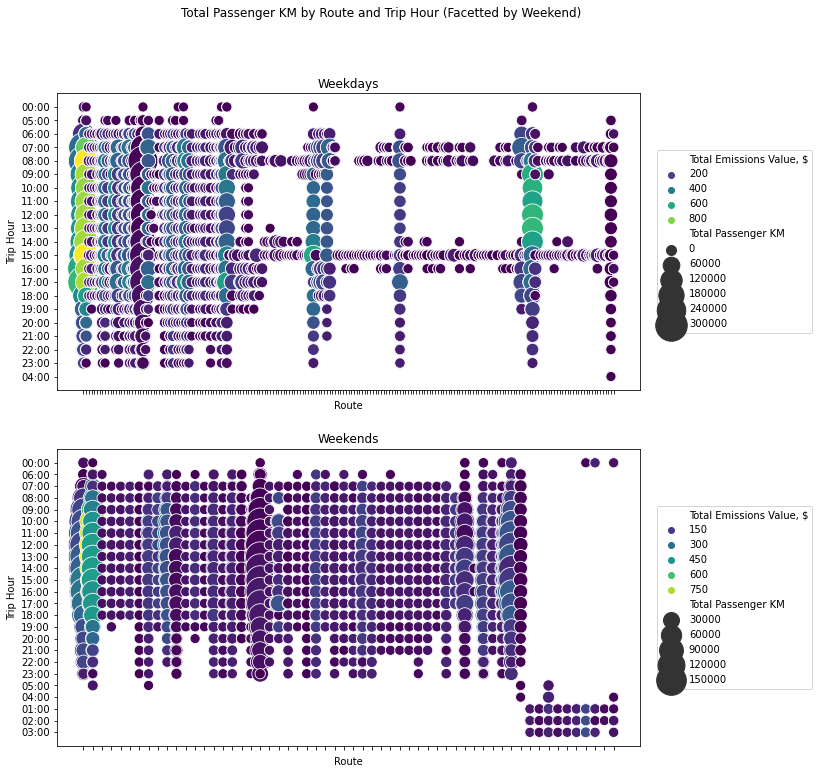

In [46]:
wlgt2022_trips_by_hour_aggregated['Weekend'] = wlgt2022_trips_by_hour_aggregated['Day of Week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')


# Create a facetted heatmap for weekdays and weekends
weekdays_df = wlgt2022_trips_by_hour_aggregated[wlgt2022_trips_by_hour_aggregated['Weekend'] == 'Weekday']
weekends_df = wlgt2022_trips_by_hour_aggregated[wlgt2022_trips_by_hour_aggregated['Weekend'] == 'Weekend']

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Total Passenger KM by Route and Trip Hour (Facetted by Weekend)')

for i, (day, day_df) in enumerate(zip(['Weekdays', 'Weekends'], [weekdays_df, weekends_df])):
    ax = axes[i]
    sns.scatterplot(data=day_df, x='Route', y='Trip Hour', size='Total Passenger KM', hue='Total Emissions Value, $',
                    palette='viridis', sizes=(100, 1000), ax=ax)
    ax.set_title(day)
    ax.set_xlabel('Route')
    ax.set_ylabel('Trip Hour')

    # Set the X-axis as categorical
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Move the legend to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

# Adjust spacing between subplots
fig.subplots_adjust(right=0.8)

plt.show()